In [78]:
!pip install xgboost

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

In [80]:
# Load data
train = pd.read_csv("/kaggle/input/dataset/Train_Data.csv")
test = pd.read_csv("/kaggle/input/dataset/Test_Data.csv")

In [81]:
print(train["age_group"].unique())
print(train["age_group"].head(10))

['Adult' 'Senior' nan]
0     Adult
1     Adult
2     Adult
3     Adult
4     Adult
5     Adult
6     Adult
7     Adult
8    Senior
9     Adult
Name: age_group, dtype: object


In [82]:
test.head()

,SEQN,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN
0,77017.0,1.0,1.0,32.2,96.0,2.0,135.0,15.11
1,75580.0,2.0,2.0,26.3,100.0,2.0,141.0,15.26
2,73820.0,1.0,2.0,28.6,107.0,2.0,136.0,8.82
3,80489.0,2.0,1.0,22.1,93.0,2.0,111.0,12.13
4,82047.0,1.0,1.0,24.7,91.0,2.0,105.0,3.12


In [83]:
train = train.dropna(subset=["age_group"])

In [84]:
train["age_group"] = train["age_group"].map({"Adult": 0, "Senior": 1})

In [85]:
train['age_group'].head(10)

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    1
9    0
Name: age_group, dtype: int64

In [86]:
print(train["age_group"].unique())
print(train["age_group"].isna().sum())

[0 1]
0


In [87]:
train.describe()

,SEQN,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN,age_group
count,1940.000000,1934.000000,1939.000000,1934.000000,1939.000000,1934.000000,1941.000000,1943.000000,1952.000000
mean,78685.510825,1.509307,1.825683,27.981127,99.466220,2.015512,115.070067,11.875265,0.160861
std,2927.348984,0.500043,0.399355,7.343856,16.738574,0.186916,46.133851,9.779149,0.367497
min,73564.000000,1.000000,1.000000,14.500000,63.000000,1.000000,40.000000,0.140000,0.000000
25%,76188.250000,1.000000,2.000000,22.800000,91.000000,2.000000,87.000000,5.795000,0.000000
50%,78719.000000,2.000000,2.000000,26.800000,97.000000,2.000000,105.000000,9.030000,0.000000
75%,81222.750000,2.000000,2.000000,31.300000,104.000000,2.000000,131.000000,14.480000,0.000000
max,83727.000000,2.000000,7.000000,70.100000,405.000000,3.000000,604.000000,102.290000,1.000000


In [88]:
y = train["age_group"]
X = train.drop(columns=["age_group"])

In [89]:
X_dropped = X.dropna()
y_dropped = y.loc[X_dropped.index]

In [90]:
combined = pd.concat([X, test], axis=0).reset_index(drop=True)

In [91]:
imputer = SimpleImputer(strategy="median")
combined_imputed = pd.DataFrame(imputer.fit_transform(combined), columns=combined.columns)

In [92]:
combined_imputed["HealthRiskScore"] = (combined_imputed["BMXBMI"] * combined_imputed["LBXGLU"] * combined_imputed["LBXIN"]) ** (1/3)

In [93]:
# Split back into train and test
X_train = combined_imputed.iloc[:len(y)]
X_test = combined_imputed.iloc[len(y):]

In [94]:
print(X.columns)

Index(['SEQN', 'RIAGENDR', 'PAQ605', 'BMXBMI', 'LBXGLU', 'DIQ010', 'LBXGLT',
       'LBXIN'],
      dtype='object')


In [95]:

X_resampled, y_resampled = X_train, y

In [96]:
if 'age_group' in X_train.columns:
    X_train = X_train.drop(columns=['age_group'])
    X_test = X_test.drop(columns=['age_group'])

In [97]:
print(y.value_counts(normalize=True))

age_group
0    0.839139
1    0.160861
Name: proportion, dtype: float64


In [98]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [99]:
scale_pos_weight = len(y[y == 0]) / len(y[y == 1])
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, scale_pos_weight=scale_pos_weight)

In [100]:
scores = cross_val_score(model, X_resampled, y_resampled, cv=cv, scoring="f1")

In [101]:
print("Cross-validated F1 scores:", scores)
print("Mean F1 score:", scores.mean())

Cross-validated F1 scores: [0.35       0.35087719 0.34188034 0.26086957 0.3559322 ]
Mean F1 score: 0.33191186069400397


In [102]:
model.fit(X_resampled, y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [103]:
X_eval_train, X_eval_val, y_eval_train, y_eval_val = train_test_split(X_train, y, test_size=0.2, stratify=y, random_state=42)
model.fit(X_eval_train, y_eval_train)
y_val_pred = model.predict(X_eval_val)
print(classification_report(y_eval_val, y_val_pred, target_names=["Adult", "Senior"]))

              precision    recall  f1-score   support

       Adult       0.85      0.87      0.86       328
      Senior       0.20      0.17      0.19        63

    accuracy                           0.76       391
   macro avg       0.52      0.52      0.52       391
weighted avg       0.74      0.76      0.75       391



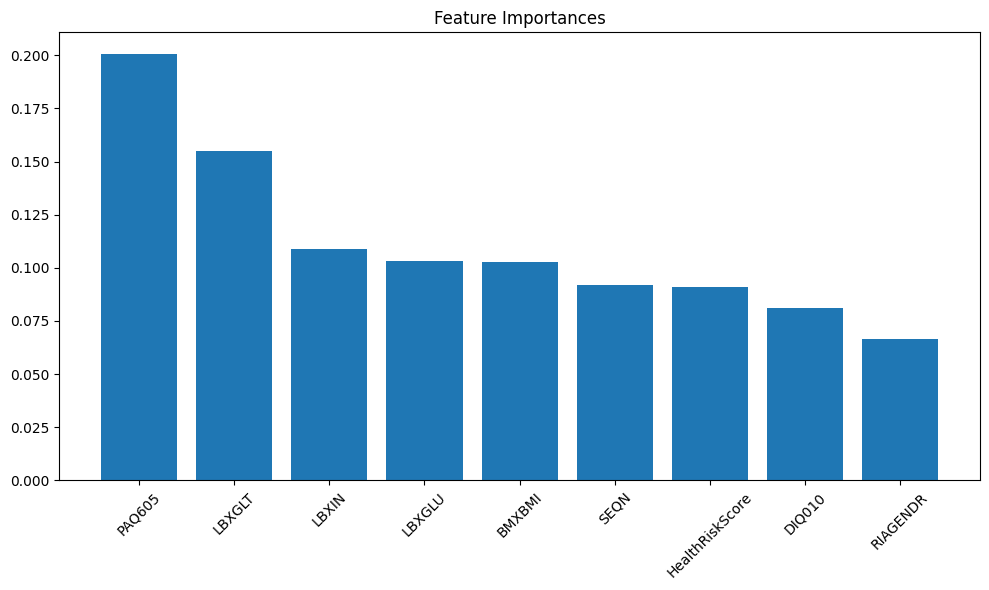

In [104]:
try:
    importances = model.feature_importances_
    features = X_train.columns
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances")
    plt.bar(range(len(features)), importances[indices], align="center")
    plt.xticks(range(len(features)), [features[i] for i in indices], rotation=45)
    plt.tight_layout()
    plt.show()
except AttributeError:
    print("Model does not support feature_importances_. Skipping plot.")


In [105]:
model.fit(X_train, y)
predictions = model.predict(X_test)

In [106]:
# Save submission
submission = pd.DataFrame({"age_group": predictions.astype(int)})
submission.to_csv("predicted_submission.csv", index=False)